In [1]:
import re
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

dataset = pd.read_csv('datasets\story_emotion3.csv')

stopword = pd.read_csv('datasets\stopwords_tl.csv')
stopwords_set = set(stopword['stopword'])

stemmer = pd.read_csv('datasets\stem_tl.csv')
word_to_stem = dict(zip(stemmer['word'], stemmer['stem']))

class_names = {
    1: 'fear',
    2: 'anger',
    3: 'joy',
    4: 'sadness',
    5: 'disgust',
    6: 'surprise'
}

replace_patterns = {
    re.compile(r"\bngayo\'y\b"): 'ngayon ay',
    re.compile(r"\bhangga\'t\b"): 'hanggang',
    re.compile(r"\b\'?y\b"): ' ay',
    re.compile(r"\b\'?t\b"): ' at',
    re.compile(r"\b\'?yan\b"): 'iyan',
    re.compile(r"\b\'?yo\b"): 'iyo',
    re.compile(r"\b\'?yon\b"): 'iyon',
    re.compile(r"\b\'?yun\b"): 'iyun',
    re.compile(r"\b\'?pagkat\b"): 'sapagkat',
    re.compile(r"\b\'?di\b"): 'hindi',
    re.compile(r"\b\'?kaw\b"): "ikaw",
    re.compile(r"\b\'?to\b"): 'ito',
    re.compile(r"\b\'?wag\b"): 'huwag',
    re.compile(r"\bgano\'n\b"): 'ganoon'
}

def data_preprocess(text, replace_patterns, word_to_stem, stopwords_set):
    text = text.lower()

    for pattern, replacement in replace_patterns.items():
        text = pattern.sub(replacement, text)

    text = re.sub("[^a-zA-Z0-9\s?!]", '', text)
    tokens = word_tokenize(text)
    text = ' '.join([word_to_stem.get(word, word) for word in tokens if word.lower() not in stopwords_set])

    return text

dataset['text'] = dataset['text'].apply(data_preprocess, replace_patterns=replace_patterns, word_to_stem=word_to_stem, stopwords_set=stopwords_set)

X = dataset['text']
Y = dataset['emotion']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

vectorizer = CountVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vectorized)
X_test_tfidf = tfidf_transformer.transform(X_test_vectorized)

k = 5  # You can adjust the value of k as needed
knn_classifier = KNeighborsClassifier(n_neighbors=k)

# Train the classifier on the TF-IDF transformed training data
knn_classifier.fit(X_train_tfidf, Y_train)

# Predict the labels for the test set
Y_pred = knn_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of KNN:", accuracy)

print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))

Accuracy of KNN: 0.6290322580645161

Classification Report:
               precision    recall  f1-score   support

        fear       0.44      0.75      0.56        20
       anger       0.50      0.52      0.51        21
         joy       0.71      0.71      0.71        21
     sadness       0.73      0.52      0.61        21
     disgust       0.85      0.55      0.67        20
    surprise       0.79      0.71      0.75        21

    accuracy                           0.63       124
   macro avg       0.67      0.63      0.63       124
weighted avg       0.67      0.63      0.64       124



C:\Users\Anna Margarita\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [2]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [3, 5, 7], 
    'weights': ['uniform', 'distance'],
    'p': [1, 2] 
}

# Initialize the kNN classifier
knn_classifier = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Perform grid search on the TF-IDF transformed training data
grid_search.fit(X_train_tfidf, Y_train)

# Print the best hyperparameters
print('Best Hyperparameters:', grid_search.best_params_)

# Get the best model
best_knn_model = grid_search.best_estimator_

# Predict the labels for the test set using the best model
Y_pred = best_knn_model.predict(X_test_tfidf)

# Evaluate the performance
accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of KNN:", accuracy)

print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))


Best Hyperparameters: {'n_neighbors': 5, 'p': 2, 'weights': 'distance'}
Accuracy of KNN: 0.6370967741935484

Classification Report:
               precision    recall  f1-score   support

        fear       0.48      0.65      0.55        20
       anger       0.59      0.62      0.60        21
         joy       0.67      0.76      0.71        21
     sadness       0.65      0.52      0.58        21
     disgust       0.73      0.55      0.63        20
    surprise       0.79      0.71      0.75        21

    accuracy                           0.64       124
   macro avg       0.65      0.64      0.64       124
weighted avg       0.65      0.64      0.64       124



In [3]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
knn_classifier = KNeighborsClassifier(n_neighbors=5, p=2, weights="distance")

# Train the classifier on the TF-IDF transformed training data
knn_classifier.fit(X_train_tfidf, Y_train)

# Predict the labels for the test set
Y_pred = knn_classifier.predict(X_test_tfidf)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy of KNN:", accuracy)

print("\nClassification Report:\n", classification_report(Y_test, Y_pred, target_names=class_names.values()))
# Define the kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='distance', p=2)

# Create a StratifiedKFold object for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the TF-IDF transformed data
cv_scores = cross_val_score(knn_classifier, X_train_tfidf, Y_train, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)

# Print the cross-validation scores
print('Cross-Validation Scores:', cv_scores)

# Print the mean and standard deviation of the cross-validation scores
print(f'Mean Accuracy: {np.mean(cv_scores):.2f}')
print(f'Standard Deviation: {np.std(cv_scores):.2f}')


Accuracy of KNN: 0.6370967741935484

Classification Report:
               precision    recall  f1-score   support

        fear       0.48      0.65      0.55        20
       anger       0.59      0.62      0.60        21
         joy       0.67      0.76      0.71        21
     sadness       0.65      0.52      0.58        21
     disgust       0.73      0.55      0.63        20
    surprise       0.79      0.71      0.75        21

    accuracy                           0.64       124
   macro avg       0.65      0.64      0.64       124
weighted avg       0.65      0.64      0.64       124

Cross-Validation Scores: [0.63636364 0.70707071 0.63636364 0.63636364 0.65656566]
Mean Accuracy: 0.65
Standard Deviation: 0.03


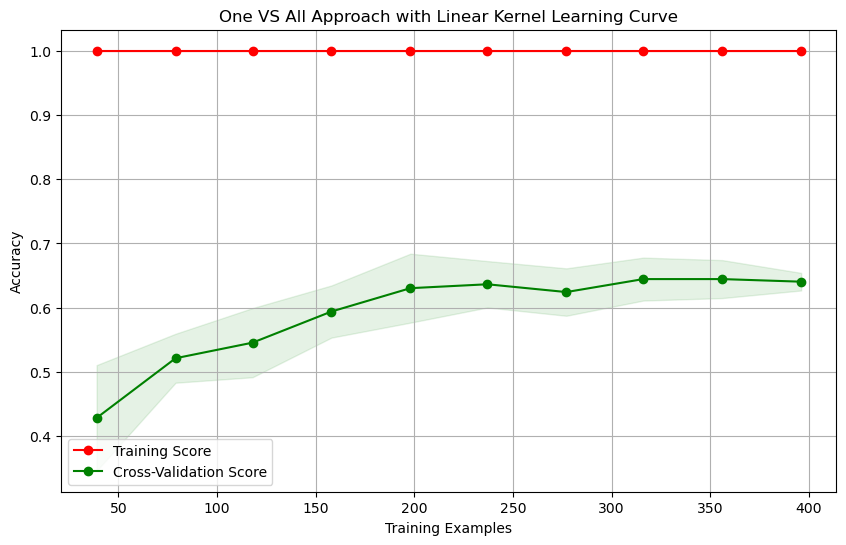

In [4]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

train_sizes, train_scores, test_scores = learning_curve(
    knn_classifier, X_train_tfidf, Y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10), random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("One VS All Approach with Linear Kernel Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Accuracy")

plt.grid()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-Validation Score")

plt.legend(loc="best")
plt.show()


In [5]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

# Define the kNN classifier
knn_classifier = KNeighborsClassifier(n_neighbors=5, weights='uniform', p=2)

# Create a StratifiedKFold object for cross-validation
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation on the TF-IDF transformed data
cv_scores = cross_val_score(knn_classifier, X_train_tfidf, Y_train, cv=stratified_kfold, scoring='accuracy', n_jobs=-1)

# Print the cross-validation scores
print('Cross-Validation Scores:', cv_scores)

# Calculate and print the variance of the cross-validation scores
variance = np.var(cv_scores)
print(f'Variance: {variance:.4f}')


Cross-Validation Scores: [0.5959596  0.64646465 0.61616162 0.61616162 0.62626263]
Variance: 0.0003


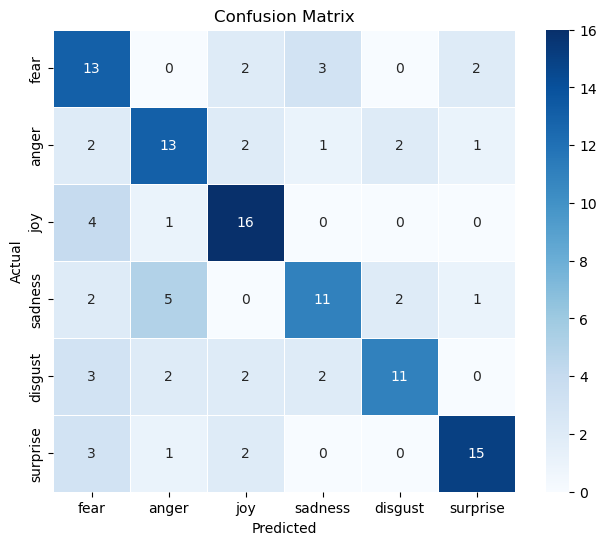

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Create the confusion matrix
conf_matrix = confusion_matrix(Y_test, Y_pred)

# Convert the confusion matrix to a DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=class_names.values(), columns=class_names.values())

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues', cbar=True, linewidths=.5, square=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
